In [1]:
%load_ext autoreload
%autoreload 2


import mahotas as mh
import numpy as np
import os
import time

from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
%matplotlib inline

import mlproof as mlp

mlproof/tifffile.py:1995: UserWarning: failed to import _tifffile.decodepackbits
  warnings.warn("failed to import %s" % module_function)
mlproof/tifffile.py:1995: UserWarning: failed to import _tifffile.decodelzw
  warnings.warn("failed to import %s" % module_function)
mlproof/tifffile.py:1995: UserWarning: failed to import _tifffile.unpackints
  warnings.warn("failed to import %s" % module_function)


In [2]:
PATCH_PATH = '/home/d/patches/cylinder_small1_rgba/'

In [19]:
def generate_patches(start_slice, end_slice):

    patch_index = 0

    all_patches_count = 0
    all_error_patches = []
    all_correct_patches = []
    
    for z in range(start_slice, end_slice):

        t0 = time.time()
        print 'working on slice', z
        input_image, input_prob, input_mask, input_gold, input_rhoana = mlp.Util.read_section('/home/d/data/cylinder/',z)

        error_patches, patches = mlp.Patch.patchify_maxoverlap(input_image, input_prob, input_mask, input_rhoana, input_gold, sample_rate=1)

        for e in error_patches:
            if e['image'].max() == 0.:
                print 'ZERRRRO', z
        
        print 'Generated', len(error_patches), 'split error patches and', len(patches), ' correct patches in', time.time()-t0, 'seconds.'
        
        
        all_error_patches += error_patches
        all_correct_patches += patches
        
    
    
    NO_PATCHES = len(all_error_patches) + len(all_correct_patches)

    print 'We have a total of',NO_PATCHES,'patches.'
    print 'Errors:',len(all_error_patches)
    print 'Correct:',len(all_correct_patches)    
    
    PATCH_BYTES = 75*75
    P_SIZE = (NO_PATCHES, 4, 75,75) # rather than raveled right now
    
    p_rgba = np.zeros(P_SIZE, dtype=np.float32)
    p_rgba_large = np.zeros(P_SIZE, dtype=np.float32)    
    
#     p_image = np.zeros(P_SIZE, dtype=np.float32)
#     p_prob = np.zeros(P_SIZE, dtype=np.float32)
#     p_binary = np.zeros(P_SIZE, dtype=np.bool)
#     p_merged_array = np.zeros(P_SIZE, dtype=np.bool)
# #     p_dyn_obj = np.zeros((NO_PATCHES, PATCH_BYTES),dtype=np.bool)
# #     p_dyn_bnd = np.zeros((NO_PATCHES, PATCH_BYTES),dtype=np.bool)
#     p_border_overlap = np.zeros(P_SIZE, dtype=np.bool)
#     p_larger_border_overlap = np.zeros(P_SIZE, dtype=np.bool)    
    p_target = np.zeros(NO_PATCHES)


    i = 0
    for p in all_error_patches:
        print p['image'].max()
        p_rgba[i][0] = p['image']
        p_rgba[i][1] = p['prob']   
        p_rgba[i][2] = p['merged_array']
        p_rgba[i][3] = p['border_overlap']
        
        p_rgba_large[i][0] = p['image']
        p_rgba_large[i][1] = p['prob']    
        p_rgba_large[i][2] = p['merged_array']
        p_rgba_large[i][3] = p['larger_border_overlap']        
        
#         p_image[i] = (p['image'].astype(np.float32)/255.)#.ravel()
#         p_prob[i] = (p['prob'].astype(np.float32)/255.)#.ravel()
#         p_binary[i] = p['binary']#.ravel()
#         p_merged_array[i] = p['merged_array']#.ravel()
# #         p_dyn_obj[i] = p['dyn_obj'].ravel()
# #         p_dyn_bnd[i] = p['dyn_bnd'].ravel()
#         p_border_overlap[i] = p['border_overlap']#.ravel()
#         p_larger_border_overlap[i] = p['larger_border_overlap']#.ravel()
        p_target[i] = 1 # <--- important
        i += 1

        
    for p in all_correct_patches:

        p_rgba[i][0] = p['image']
        p_rgba[i][1] = p['prob']    
        p_rgba[i][2] = p['merged_array']
        p_rgba[i][3] = p['border_overlap']
        
        p_rgba_large[i][0] = p['image']
        p_rgba_large[i][1] = p['prob']       
        p_rgba_large[i][2] = p['merged_array']
        p_rgba_large[i][3] = p['larger_border_overlap']        
        
#         p_image[i] = (p['image'].astype(np.float32)/255.)#.ravel()
#         p_prob[i] = (p['prob'].astype(np.float32)/255.)#.ravel()
#         p_binary[i] = p['binary']#.ravel()
#         p_merged_array[i] = p['merged_array']#.ravel()
# #         p_dyn_obj[i] = p['dyn_obj'].ravel()
# #         p_dyn_bnd[i] = p['dyn_bnd'].ravel()
#         p_border_overlap[i] = p['border_overlap']#.ravel()
#         p_larger_border_overlap[i] = p['larger_border_overlap']#.ravel()
        p_target[i] = 0 # <--- important
        i+=1
        
    
#     return p_image, p_prob, p_binary, p_merged_array, p_dyn_obj, p_dyn_bnd, p_border_overlap, p_larger_border_overlap, p_target
#     return p_image, p_prob, p_binary, p_merged_array, p_border_overlap, p_larger_border_overlap, p_target
        return p_rgba, p_rgba_large, p_target



def shuffle_in_unison_inplace(a, b, c):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p], c[p]



def run(start_slice, end_slice, filename):
    
    if not os.path.exists(PATCH_PATH):
        os.makedirs(PATCH_PATH)
    
    p = generate_patches(start_slice, end_slice)
    
    shuffled = shuffle_in_unison_inplace(p[0],
                                         p[1],
                                         p[2]
                                        )
    
    print 'saving..'
    np.savez(PATCH_PATH+filename+'.npz', rgba=shuffled[0],
                                         rgba_large=shuffled[1])
    np.savez(PATCH_PATH+filename+'_targets.npz', targets=shuffled[2])
    print 'Done!'
    
#     return correct, split, shuffled


In [ ]:
run(40,50,'training')
run(60,62,'test')

working on slice 40
Loading z00000040.png


In [6]:
X_train, y_train, X_test, y_test = mlp.Patch.load('cylinder_small1_rgba')

Loaded /home/d/patches//cylinder_small1_rgba/ in 0.111925840378 seconds.


In [9]:
X_train['rgba'].shape

(24296, 4, 75, 75)

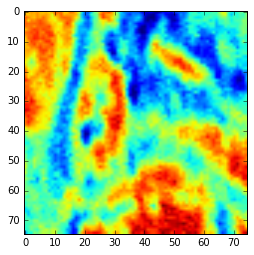

In [14]:
imshow(X_train['rgba'][1][0])

In [13]:
y_train[1]

1